# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Dell\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('../amazon-fine-food-reviews/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)


Number of data points in our data (525814, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'at', 'more', 'wouldn', 'how', 'there', 'into', 'which', "it's", 'or', 'as', 'no', 'only', 'didn', 'that', "couldn't", "you'd", 'were', 'such', 'hers', 'll', 'any', 'over', 'shan', 'shouldn', 'his', 'than', 'of', 'and', 'off', 't', 'mightn', 'be', 'an', 'to', 'with', 'a', 'been', 'you', 'did', 'ours', "weren't", 'for', 'ain', 'weren', 'on', 'below', 'myself', 're', 'through', 'because', 'once', 'its', 'who', 'if', 'the', "hasn't", 'very', 'own', "didn't", "wasn't", "wouldn't", 'is', 'your', "shan't", 'ourselves', 'couldn', 'himself', 'was', 'again', 'aren', 'has', 'what', 'yours', 'had', 'further', "haven't", 'then', 'other', 'wasn', 'he', 'are', 'won', 'i', 'my', "won't", 'am', 'doing', 'each', 'me', 'whom', 'where', 'while', 'doesn', 'out', 'they', 'these', "she's", "don't", 'she', 'have', 'between', 'now', 'it', 'itself', 'under', 'just', 'm', 'their', 'o', "hadn't", 'yourself', 'we', 'our', "needn't", "should've", 'before', 'most', 'here', 'why', 'should', 'y', 'both', 'haven', "i

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
#if not os.path.isfile('final.sqlite'):
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1


100%|████████████████████████████████████| 364171/364171 [15:56<00:00, 380.76it/s]


In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
final_np=final.head(100000)

In [15]:
final_np['Score'].value_counts()

positive    85197
negative    14803
Name: Score, dtype: int64

In [16]:
# Sorting data based on time
final_np["Time"] = pd.to_datetime(final_np["Time"], unit = "s")
final_np = final_np.sort_values(by = "Time")

In [17]:
final_np.head()

Id   ProductId          UserId               ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
138683  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
417839  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
346055  374359  B00004CI84  A344SMIA5JECGM           Vincent P. Ross   
417838  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

        HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
138706                     0                       0  positive 1999-10-08   
138683                     2                       2  positive 1999-10-25   
417839                     0                       0  positive 1999-12-02   
346055                     1                       2  positive 1999-12-06   
417838                     0                       0  positive 2000-01-03   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   
417839                               Entertainingl Funny!   
346055                            A modern day fairy tale   
417838                                         FANTASTIC!   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138683  I can remember seeing the show when it aired o...   
417839  Beetlejuice is a well written movie ..... ever...   
346055  A twist of rumplestiskin captured on film, sta...   
417838  Beetlejuice is an excellent and funny movie. K...   

                                              CleanedText  
138706  witti littl book make son laugh loud recit car...  
138683  rememb see show air televis year ago child sis...  
417839  beetlejuic well written movi everyth excel act...  
346055  twist rumplestiskin captur film star michael k...  
417838  beetlejuic excel funni movi keaton hilari wack...

# Optimal Parameter check for max depth in Decision Tree

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def dt_grid(X_train,y_train):
    clf = DecisionTreeClassifier(class_weight='balanced')
    param_grid = {'max_depth':[3,5,7,9,11,13,15]}
    gscv = GridSearchCV(clf,param_grid,cv=10,verbose=1,scoring='f1_micro',n_jobs=-1)
    gscv_fit=gscv.fit(X_train,y_train)
    print(pd.DataFrame(gscv_fit.cv_results_).sort_values('mean_test_score', ascending=False).head())
    print("Best HyperParameter: ",gscv.best_params_)
    print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))

In [19]:
def confusion_matrix_np(cm):
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [20]:
def show_most_informative_features(vectorizer, clf, n=15):
    feature_names = vectorizer.get_feature_names()
    features = sorted(zip(clf.feature_importances_, feature_names))
    top = features[:-(n + 1):-1]
    print("Top 15 Features:")
    for (coef_1, fn_1) in top:
        print("%-15s\t%.4f\t" % (fn_1,coef_1))      
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

In [21]:
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
def dtree_graph(estimator,vectorizer,name):
    graph = Source(tree.export_graphviz(estimator, out_file=None
       , feature_names=vectorizer.get_feature_names(), class_names=['negative', 'positive'] 
       , filled = True))
    display(SVG(graph.pipe(format='svg')))
    graph.format = 'png'
    graph.render(filename=name,view=True)
    

# [7.2.2] Bag of Words (BoW)

In [22]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [23]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [25]:
#BOW
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train)


In [26]:
X_test=count_vect.transform(X_test)

# GridSearchCV

In [27]:
#DTGrid
dt_bow= dt_grid(X_train, y_train)
dt_bow

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  4.6min finished


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6      18.573267      1.535123         0.090948        0.023722   
5      18.290333      3.478771         0.102741        0.012891   
4      15.820508      2.163080         0.157120        0.039827   
3      11.414731      0.909118         0.129926        0.030921   
2       7.932326      0.954384         0.115535        0.030782   

  param_max_depth             params  split0_test_score  split1_test_score  \
6              15  {'max_depth': 15}           0.757463           0.748607   
5              13  {'max_depth': 13}           0.705328           0.694472   
4              11  {'max_depth': 11}           0.739751           0.673475   
3               9   {'max_depth': 9}           0.673618           0.666048   
2               7   {'max_depth': 7}           0.652335           0.651764   

   split2_test_score  split3_test_score       ...         split2_train_score  \
6           0.754749           0.758320       ..

In [28]:
dt = DecisionTreeClassifier(max_depth=15,class_weight='balanced')
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

In [29]:
# Accuracy on train data
train_acc_bow = dt.score(X_train, y_train)
print("Train Accuracy", train_acc_bow*100)

Train Accuracy 78.19142857142857


In [30]:
# Accuracy on test data
test_acc_bow = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_bow)

Test Accuracy  75.67666666666668


In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 3252,  1135],
       [ 6162, 19451]], dtype=int64)

In [32]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.35      0.74      0.47      4387
   positive       0.94      0.76      0.84     25613

avg / total       0.86      0.76      0.79     30000



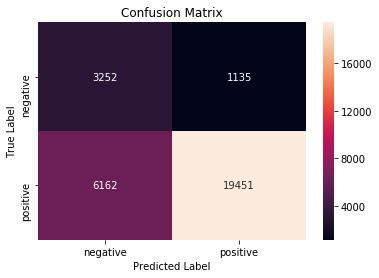

In [33]:
confusion_matrix_np(cm)

In [34]:
show_most_informative_features(count_vect,dt)

Top 15 Features:
great          	0.1298	
love           	0.0822	
disappoint     	0.0786	
best           	0.0782	
delici         	0.0529	
perfect        	0.0280	
excel          	0.0266	
favorit        	0.0250	
good           	0.0237	
bad            	0.0212	
money          	0.0202	
would          	0.0199	
nice           	0.0172	
thought        	0.0164	
tast           	0.0125	


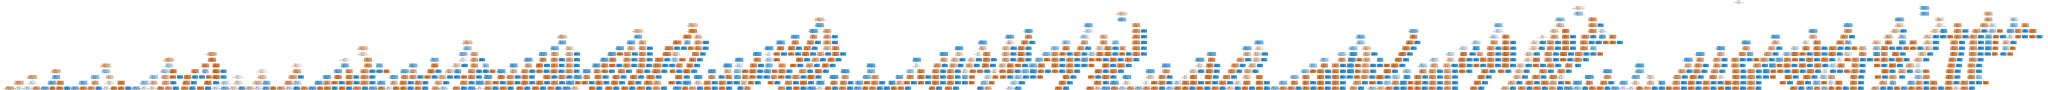

In [35]:
dtree_graph(dt,count_vect,'BOW')

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [36]:
#with open('positive_words.pkl', 'rb') as f:
#    all_positive_words = pickle.load(f)
#with open('negitive_words.pkl', 'rb') as f:
#   all_negative_words = pickle.load(f)
    
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [37]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [38]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [40]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
bicount_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
X_train = bicount_vect.fit_transform(X_train)


In [41]:
X_test=bicount_vect.transform(X_test)

# GridSearchCV

In [42]:
#DTGrid
dt_bow= dt_grid(X_train, y_train)
dt_bow

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 71.0min finished


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6     350.483218     77.839151         0.185538        0.072961   
5     303.436311     13.186814         0.160256        0.029060   
4     201.427034     25.706324         0.166806        0.058419   
3     228.428412      8.759796         0.170811        0.028957   
2     203.041934      8.201246         0.154414        0.014893   

  param_max_depth             params  split0_test_score  split1_test_score  \
6              15  {'max_depth': 15}           0.742037           0.749464   
5              13  {'max_depth': 13}           0.710898           0.702471   
4              11  {'max_depth': 11}           0.739180           0.674332   
3               9   {'max_depth': 9}           0.679332           0.671190   
2               7   {'max_depth': 7}           0.658335           0.652621   

   split2_test_score  split3_test_score       ...         split2_train_score  \
6           0.759034           0.747036       ..

In [43]:
dt = DecisionTreeClassifier(max_depth=15,class_weight='balanced')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)


In [44]:
# Accuracy on train data
train_acc_bow = dt.score(X_train, y_train)
print("Train Accuracy", train_acc_bow*100)

Train Accuracy 76.78142857142856


In [45]:
# Accuracy on test data
test_acc_bow = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_bow)

Test Accuracy  74.37333333333333


In [46]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 3343,  1044],
       [ 6644, 18969]], dtype=int64)

In [47]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.33      0.76      0.47      4387
   positive       0.95      0.74      0.83     25613

avg / total       0.86      0.74      0.78     30000



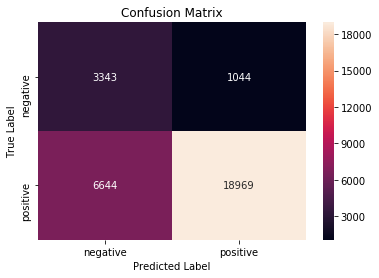

In [48]:
confusion_matrix_np(cm)

In [49]:
show_most_informative_features(bicount_vect,dt)

Top 15 Features:
great          	0.1279	
love           	0.0813	
disappoint     	0.0775	
best           	0.0766	
delici         	0.0523	
perfect        	0.0266	
excel          	0.0262	
favorit        	0.0245	
bad            	0.0244	
good           	0.0236	
money          	0.0187	
high recommend 	0.0171	
nice           	0.0171	
thought        	0.0162	
would          	0.0152	


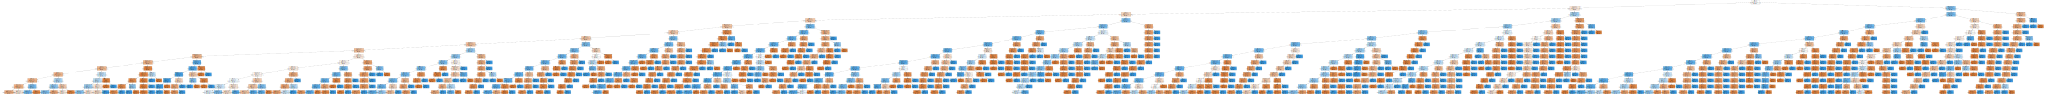

In [50]:
dtree_graph(dt,bicount_vect,'Bigram BOW')

# [7.2.5] TF-IDF

In [51]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)


shape of X: (100000,)


In [52]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [54]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)

In [55]:
X_test = tf_idf_vect.transform(X_test)

# GridSearchCV

In [56]:
#DTGrid
dt_tfidf= dt_grid(X_train, y_train)
dt_tfidf

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  7.5min finished


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6      39.732078      9.951601         0.158872        0.086810   
5      33.469027      3.055475         0.163750        0.081749   
4      23.906538      1.771936         0.165597        0.056523   
3      19.871817      2.774113         0.164798        0.038633   
2      17.262949      1.178918         0.180570        0.045460   

  param_max_depth             params  split0_test_score  split1_test_score  \
6              15  {'max_depth': 15}           0.706756           0.711898   
5              13  {'max_depth': 13}           0.696472           0.705328   
4              11  {'max_depth': 11}           0.657763           0.671618   
3               9   {'max_depth': 9}           0.683188           0.675332   
2               7   {'max_depth': 7}           0.608056           0.597200   

   split2_test_score  split3_test_score       ...         split2_train_score  \
6           0.705471           0.702185       ..

In [57]:
dt = DecisionTreeClassifier(max_depth=15,class_weight='balanced')
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

In [58]:
# Accuracy on train data
train_acc_tfidf = dt.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidf*100)

Train Accuracy 74.38428571428571


In [59]:
# Accuracy on test data
test_acc_tfidf = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_tfidf)

Test Accuracy  71.65333333333334


In [60]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 3435,   952],
       [ 7552, 18061]], dtype=int64)

In [61]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.31      0.78      0.45      4387
   positive       0.95      0.71      0.81     25613

avg / total       0.86      0.72      0.76     30000



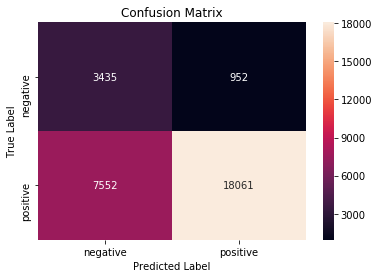

In [62]:
confusion_matrix_np(cm)

In [63]:
show_most_informative_features(tf_idf_vect,dt)

Top 15 Features:
great          	0.1463	
love           	0.1000	
best           	0.0839	
disappoint     	0.0732	
delici         	0.0518	
perfect        	0.0354	
good           	0.0307	
excel          	0.0272	
favorit        	0.0259	
money          	0.0253	
nice           	0.0202	
easi           	0.0160	
find           	0.0157	
bad            	0.0146	
aw             	0.0121	


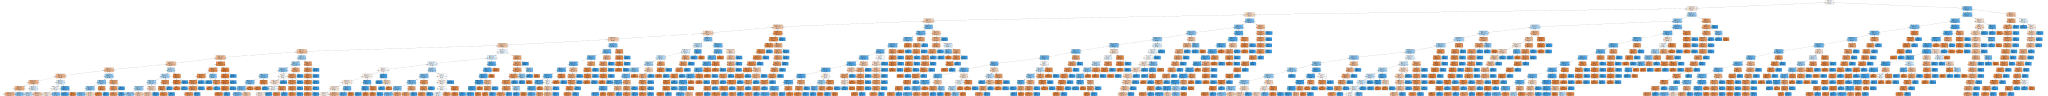

In [64]:
dtree_graph(dt,tf_idf_vect,'TF-IDF')

# [7.2.6] Word2Vec

In [85]:
from gensim.models import Word2Vec

In [86]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)


shape of X: (100000,)


In [87]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


# [7.2.7] Avg W2V

In [89]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
w2v_dim=300    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=w2v_dim, workers=4)

w2v_words = list(w2v_model.wv.vocab)

In [90]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(w2v_dim) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(w2v_dim) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

X_train = train_vectors
X_test = test_vectors

# GridSearchCV

In [71]:
#DTGrid
dt_avgw2v= dt_grid(X_train, y_train)
dt_avgw2v

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 19.6min finished


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6      71.171253      5.757080         0.098046        0.032205   
5      70.572898      1.850419         0.115134        0.022405   
4      65.909665      0.852792         0.117433        0.031393   
3      73.229400     13.559576         0.118439        0.021949   
2      57.353151      8.388948         0.117986        0.019475   

  param_max_depth             params  split0_test_score  split1_test_score  \
6              15  {'max_depth': 15}           0.818740           0.813741   
5              13  {'max_depth': 13}           0.802028           0.803171   
4              11  {'max_depth': 11}           0.784745           0.784031   
3               9   {'max_depth': 9}           0.776746           0.756749   
2               7   {'max_depth': 7}           0.746608           0.750750   

   split2_test_score  split3_test_score       ...         split2_train_score  \
6           0.810170           0.812170       ..

In [91]:
dt = DecisionTreeClassifier(max_depth=15,class_weight='balanced')
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

In [92]:
# Accuracy on train data
train_acc_avgw2v = dt.score(X_train, y_train)
print("Train Accuracy", train_acc_avgw2v*100)


Train Accuracy 93.68857142857144


In [93]:
# Accuracy on test data
test_acc_avgw2v = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_avgw2v)

Test Accuracy  81.98333333333333


In [94]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 2574,  1813],
       [ 3592, 22021]], dtype=int64)

In [95]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.42      0.59      0.49      4387
   positive       0.92      0.86      0.89     25613

avg / total       0.85      0.82      0.83     30000



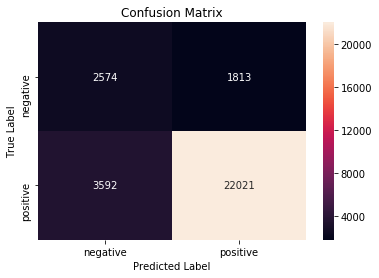

In [96]:
confusion_matrix_np(cm)

# TFIDF-W2V

In [97]:
# Train Label
X = final_np["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [98]:
# Class label
y = final_np["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, X_test.shape)

(70000,) (70000,) (30000,)


In [100]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [101]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_train: # for each review/sentence 
    sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [102]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in sent_of_test: # for each review/sentence 
    sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test

# GridSearchCV

In [103]:
#SVMGrid
dt_tfidfw2v= dt_grid(X_train, y_train)
dt_tfidfw2v


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 21.7min finished


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6      88.688060      9.249549         0.126828        0.031289   
5     100.054614      3.857397         0.138430        0.046403   
4      87.759068     12.371465         0.147480        0.055385   
3      65.212994      4.142395         0.126727        0.035976   
2      54.545028      2.297433         0.131725        0.031280   

  param_max_depth             params  split0_test_score  split1_test_score  \
6              15  {'max_depth': 15}           0.804457           0.804457   
5              13  {'max_depth': 13}           0.784888           0.788887   
4              11  {'max_depth': 11}           0.757892           0.763891   
3               9   {'max_depth': 9}           0.727610           0.748036   
2               7   {'max_depth': 7}           0.711470           0.728753   

   split2_test_score  split3_test_score       ...         split2_train_score  \
6           0.805456           0.803599       ..

In [104]:
dt = DecisionTreeClassifier(max_depth=15,class_weight='balanced')
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

In [105]:
# Accuracy on train data
train_acc_tfidfw2v = dt.score(X_train, y_train)
print("Train Accuracy", train_acc_tfidfw2v*100)

Train Accuracy 92.96571428571428


In [106]:
# Accuracy on test data
test_acc_tfidfw2v = accuracy_score(y_test,y_pred) * 100
print("Test Accuracy ",test_acc_tfidfw2v)

Test Accuracy  79.86


In [107]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 2435,  1952],
       [ 4090, 21523]], dtype=int64)

In [108]:
# Classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

   negative       0.37      0.56      0.45      4387
   positive       0.92      0.84      0.88     25613

avg / total       0.84      0.80      0.81     30000



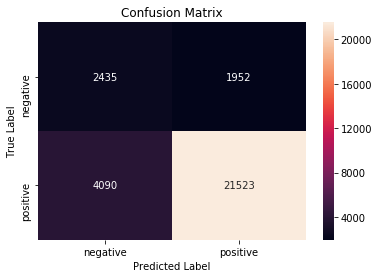

In [109]:
confusion_matrix_np(cm)

# Conclusion
* Avg-W2V Vectorizer performs well with test accuracy equal to 81.98% and f1-score 0.83.

In [110]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer","CV","Max Depth","Train Accuracy","Test Accuracy","F-1 Score"]

x.add_row(["Unigram BOW", "GridSearchCV",15,78.19,75.67,0.79])
x.add_row(["Bigram BOW", "GridSearchCV",15,76.78,74.37,0.78])
x.add_row(["TF-IDF", "GridSearchCV",15,74.38,71.65,0.76])
x.add_row(["AVG-W2V", "GridSearchCV",15,93.6,81.98,0.83])
x.add_row(["TFIDF-W2V", "GridSearchCV",15,92.96,79.86,0.81])

print("Performance Table")
print(x)

Performance Table
+-------------+--------------+-----------+----------------+---------------+-----------+
|  Vectorizer |      CV      | Max Depth | Train Accuracy | Test Accuracy | F-1 Score |
+-------------+--------------+-----------+----------------+---------------+-----------+
| Unigram BOW | GridSearchCV |     15    |     78.19      |     75.67     |    0.79   |
|  Bigram BOW | GridSearchCV |     15    |     76.78      |     74.37     |    0.78   |
|    TF-IDF   | GridSearchCV |     15    |     74.38      |     71.65     |    0.76   |
|   AVG-W2V   | GridSearchCV |     15    |      93.6      |     81.98     |    0.83   |
|  TFIDF-W2V  | GridSearchCV |     15    |     92.96      |     79.86     |    0.81   |
+-------------+--------------+-----------+----------------+---------------+-----------+
